# **Log Analysis** (AWS DeepRacer)

- Author: ai-castle
  - https://www.ai-castle.com
 - edu@ai-castle.com

- upload log.tar.gz

In [1]:
from google.colab import files
uploaded = files.upload()
uploaded_file_name = list(uploaded.keys())[0]

Saving my-first-model-training_job_Fe6u4o1dS_62RzmaIkUMYw_logs.tar.gz to my-first-model-training_job_Fe6u4o1dS_62RzmaIkUMYw_logs.tar.gz


## [1] import & unzip

- track github

In [2]:
!git clone https://github.com/aws-deepracer-community/deepracer-race-data.git

Cloning into 'deepracer-race-data'...
remote: Enumerating objects: 260461, done.
remote: Counting objects: 100% (1377/1377), done.
remote: Compressing objects: 100% (609/609), done.
remote: Total 260461 (delta 973), reused 1164 (delta 768), pack-reused 259084
Receiving objects: 100% (260461/260461), 167.81 MiB | 39.18 MiB/s, done.
Resolving deltas: 100% (186886/186886), done.
Updating files: 100% (28803/28803), done.


- import

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

- unzip

In [4]:
import tarfile

# unzip
tar = tarfile.open(uploaded_file_name, "r:gz")
file_infos = tar.getmembers()
file_names =  [i.get_info()['name'] for i in file_infos]
tar.extractall('log_unzip')
tar.close()

# uzip file configuration
iteration_file_names = []
for i in file_names :
    if i[-13:] == 'iteration.csv' :
        iteration_file_names.append(i)
    elif i[-13:] == 'sagemaker.log' :
        sagemaker_file_name = i
    elif i[-13:] == 'robomaker.log' :
        robomaker_file_name = i
    elif i[-4:] == 'json' :
        metrics_file_name = i

sagemaker_file_path = 'log_unzip/' + sagemaker_file_name
robomaker_file_path = 'log_unzip/' + robomaker_file_name
metrics_file_path = 'log_unzip/' + metrics_file_name

df_iteration_file = pd.DataFrame()
df_iteration_file['file_name'] = iteration_file_names
df_iteration_file['file_path'] = 'log_unzip/' + df_iteration_file['file_name']
df_iteration_file['iteration_idx'] = df_iteration_file['file_name'].apply(lambda x : x.split('/')[-1].split('-')[0]).astype('int')
df_iteration_file = df_iteration_file.sort_values('iteration_idx').reset_index(drop=True)

## [2] Track Visualization

- get track info

In [5]:
import re

# world_name from robomaker log
with open(robomaker_file_path, 'r') as f :
  robomaker_log = f.read()
# world_name = robomaker_log.split("'WORLD_NAME':")[1].split(',')[0].split("'")[1]
world_name = re.search(r"'WORLD_NAME':\s*'([^']+)'", robomaker_log).group(1)
world_numpy_file_name = world_name + '.npy'

numpy_file_folder = "deepracer-race-data/raw_data/tracks/npy"
numpy_file_path = os.path.join(numpy_file_folder, world_numpy_file_name)
track_arr = np.load(numpy_file_path)

- track visualization

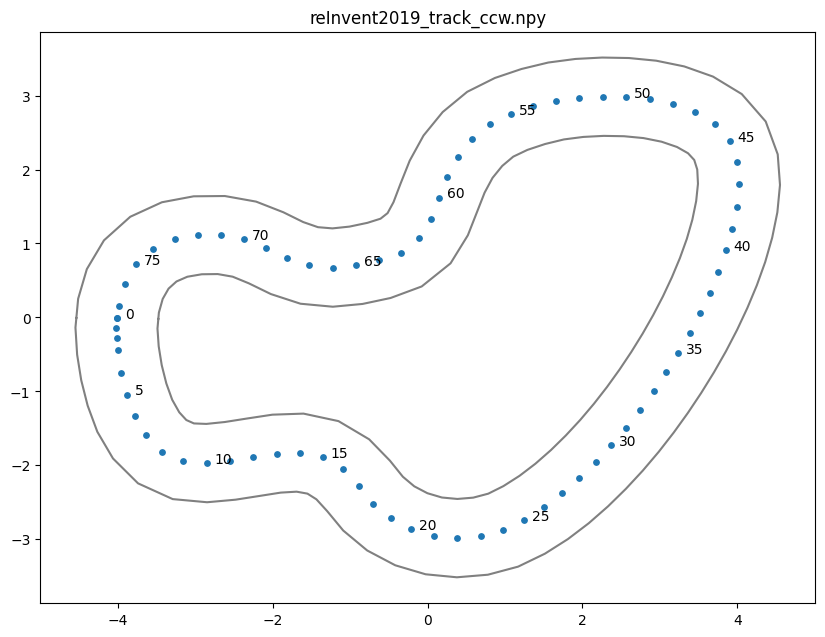

In [6]:
def track_show(npy_name, index_interval = 5, index_fontsize=10):
    npy_folder_path = "deepracer-race-data/raw_data/tracks/npy"
    numpy_file_path = os.path.join(npy_folder_path, npy_name)
    track_arr = np.load(numpy_file_path)

    # Get track waypoints
    track_C = track_arr[:,[0,1]]  # Center coordinate of the track
    track_L = track_arr[:,[2,3]]  # Left coordinate of the track
    track_R = track_arr[:,[4,5]]  # Right coordinate of the track

    # Visualization
    w = track_C[:,0].max() - track_C[:,0].min()
    h = track_C[:,1].max() - track_C[:,1].min()
    plt.figure(figsize = (10, 10 * (h/w)))
    plt.scatter(track_C[:,0],track_C[:,1], s = 15)
    plt.plot(track_L[:,0],track_L[:,1], c='gray')
    plt.plot(track_R[:,0],track_R[:,1], c='gray')

    # Show indices
    for i, (x, y) in enumerate(track_C) :
        if i % index_interval == 0 :
            plt.text(x+0.1, y, i, fontsize=index_fontsize)

    # Output
    plt.title(npy_name)
    plt.show()

track_show(
    npy_name = world_numpy_file_name,   # Name of the numpy file containing the track waypoints
    index_interval = 5,     # Interval between the indices of the waypoints
    index_fontsize = 10,    # Font size of the waypoint indices
)

## [3] n-iteration.csv Log files

- load n-iteration.csv

In [7]:
# iteration.csv preprocessing
df_list = []
df_iteration_file_len = df_iteration_file.shape[0]
for i in range(df_iteration_file_len) : 
  target_row = df_iteration_file.iloc[i]
  target_iteration = target_row['iteration_idx']
  target_path = target_row['file_path']

  with open(target_path) as f :
      csv_readlines = f.readlines()

  columns = ['iteration'] + csv_readlines[0].replace('\n','').split(',')
  data = []
  for line_text in csv_readlines[1:] :
    row = eval('[' + line_text.replace('\n','').replace('prepare', "'prepare'").replace('in_progress', "'in_progress'").replace('off_track', "'off_track'").replace('crashed',"'off_track'").replace('lap_complete',"'lap_complete'") + ']')
    data.append([target_iteration] + row)

  df_target = pd.DataFrame(columns = columns, data = data)
  df_list.append(df_target)

df_data = pd.concat(df_list).reset_index(drop=True)
df_data

,iteration,episode,steps,X,Y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration
0,0,0,1.0,-4.000162,-0.283985,-86.453139,0.0,1.0,5,0.000,False,True,0.607026,0,23.090893,20.311,prepare,0.0
1,0,0,2.0,-4.000159,-0.283816,-86.450466,0.0,0.5,4,1.000,False,True,0.606300,0,23.090893,20.376,in_progress,0.0
2,0,0,3.0,-4.000291,-0.291572,-86.605303,-15.0,0.5,2,1.000,False,True,0.639789,0,23.090893,20.447,in_progress,0.0
3,0,0,4.0,-4.004802,-0.312423,-88.049208,-30.0,0.5,0,1.000,False,True,0.728703,1,23.090893,20.507,in_progress,0.0
4,0,0,5.0,-4.011036,-0.334702,-89.737725,-30.0,0.5,0,1.000,False,True,0.823333,1,23.090893,20.576,in_progress,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13312,5,119,122.0,-0.541477,-1.692777,-6.659345,0.0,1.0,5,0.001,False,False,23.822584,14,23.090893,1456.408,in_progress,0.0
13313,5,119,123.0,-0.501015,-1.707051,-8.945241,0.0,1.0,5,0.001,False,False,23.986173,14,23.090893,1456.472,in_progress,0.0
13314,5,119,124.0,-0.457370,-1.720286,-10.483411,-30.0,1.0,1,0.001,False,False,24.155702,15,23.090893,1456.545,in_progress,0.0
13315,5,119,125.0,-0.393824,-1.751534,-14.889125,-30.0,1.0,1,0.001,False,False,24.440924,15,23.090893,1456.604,in_progress,0.0


**Explanation of Columns**

- `iteration` : a set of episodes
- `episode` : a set of steps
- `step` : the order of the current step in the episode
- `X` : the x-coordinate of the vehicle
- `Y` : the y-coordinate of the vehicle
- `yaw` : the heading (i.e., the front angle) of the vehicle
- `steer` : the angle of the steering wheel of the vehicle
- `throttle` : the speed of the vehicle
- `action` : an action taken by the agent. 
  > For discrete action spaces, it represents the index of the action. For continuous action spaces, it consists of the angle of the steering wheel (action_1) and the speed (action_2) of the vehicle.
- `reward` : the reward received at the current step
- `all_wheels_on_track` : a Boolean value indicating whether all wheels of the vehicle are located within the track or not
- `progress` : the progress rate of the current episode
- `closest_waypoint` : the index of the closest waypoint to the vehicle
- `tstamp` : the total time elapsed during the training.


## [4] Log Analysis

### 4.1. Location

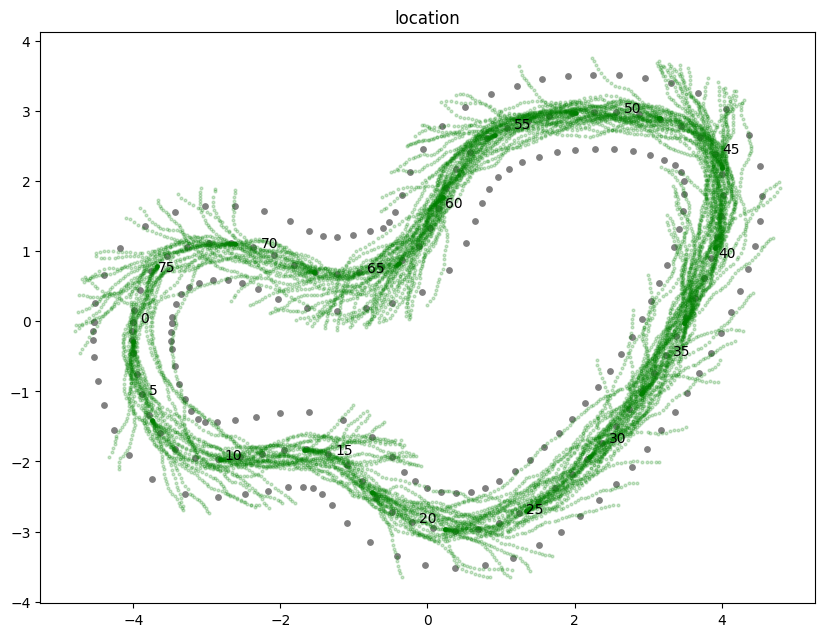

In [8]:
# Get track waypoints
track_C = track_arr[:,[0,1]]  # Center coordinates of the track
track_L = track_arr[:,[2,3]]  # Left coordinates of the track
track_R = track_arr[:,[4,5]]  # Right coordinates of the track

# Visualize the track
w = track_C[:,0].max() - track_C[:,0].min()
h = track_C[:,1].max() - track_C[:,1].min()
plt.figure(figsize = (10, 10 * (h/w)))
plt.scatter(track_C[:,0],track_C[:,1], c = 'gray', s = 15)
plt.scatter(track_L[:,0],track_L[:,1], c = 'gray', s = 15)
plt.scatter(track_R[:,0],track_R[:,1], c = 'gray', s = 15)

# Visualize waypoint indices
for i, (x, y) in enumerate(track_C) :
    if i % 5 == 0 :
        plt.text(x+0.1, y, i, fontsize=10)

# Visualize the log trajectory
plt.scatter(x = df_data['X'], y = df_data['Y'], c = 'green', s = 4, alpha = 0.2)

# Output
plt.title("location")
plt.show()


### 4.2. Speed

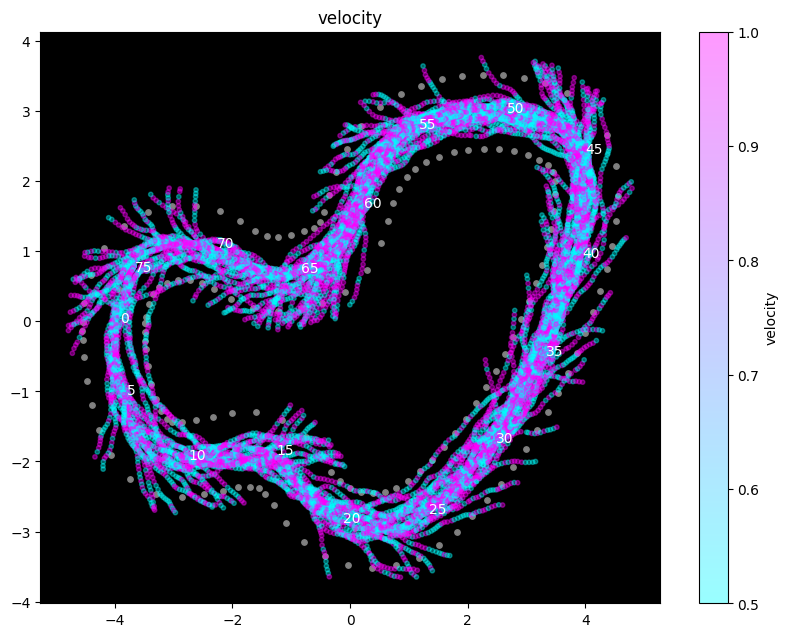

In [9]:
# Visualize the track
w = track_C[:,0].max() - track_C[:,0].min()
h = track_C[:,1].max() - track_C[:,1].min()
plt.figure(figsize = (10, 10 * (h/w)))
plt.scatter(track_C[:,0],track_C[:,1], c = 'gray', s = 15)
plt.scatter(track_L[:,0],track_L[:,1], c = 'gray', s = 15)
plt.scatter(track_R[:,0],track_R[:,1], c = 'gray', s = 15)

# Visualize the trajectory with different colors according to the speed
plt.scatter(x = df_data['X'], y = df_data['Y'], c = df_data['throttle'], s = 10, alpha = 0.4, cmap = plt.cm.cool)
plt.colorbar(label='velocity')

# Visualize waypoint indices
for i, (x, y) in enumerate(track_C) :
    if i % 5 == 0 :
        plt.text(x+0.1, y, i, fontsize=10, c = 'white')

# Output
plt.title('velocity')
plt.gca().set_facecolor('black')  # Background color
plt.show()


### 4.3. Reward

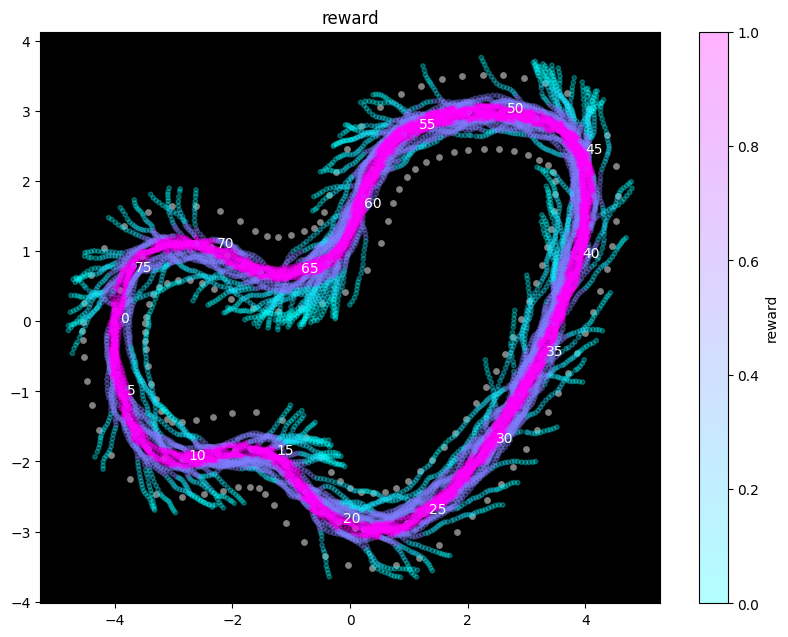

In [10]:
# Visualize the track
w = track_C[:,0].max() - track_C[:,0].min()
h = track_C[:,1].max() - track_C[:,1].min()
plt.figure(figsize = (10, 10 * (h/w)))
plt.scatter(track_C[:,0],track_C[:,1], c = 'gray', s = 15)
plt.scatter(track_L[:,0],track_L[:,1], c = 'gray', s = 15)
plt.scatter(track_R[:,0],track_R[:,1], c = 'gray', s = 15)

# Visualize the trajectory with different colors according to the reward
plt.scatter(x = df_data['X'], y = df_data['Y'], c = df_data['reward'], s = 10, alpha = 0.3, cmap = plt.cm.cool)
plt.colorbar(label='reward')

# Visualize waypoint indices
for i, (x, y) in enumerate(track_C) :
    if i % 5 == 0 :
        plt.text(x+0.1, y, i, fontsize=10, c = 'white')

# Output
plt.title('reward')
plt.gca().set_facecolor('black') # Background color
plt.show()

### 4.4. Dangerous

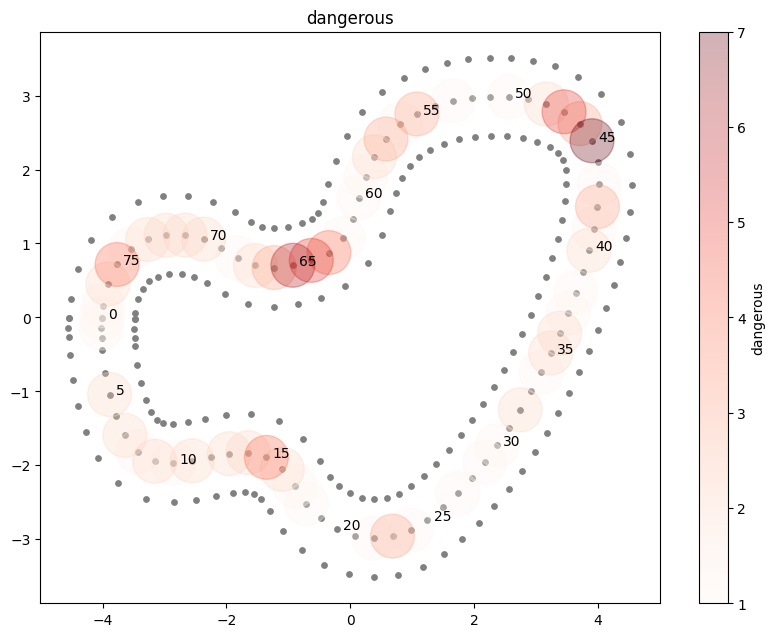

In [11]:
# off_track
df_last_waypoint = df_data[['episode','closest_waypoint']][df_data['episode_status'] == 'off_track']
df_last_waypoint = df_last_waypoint.rename({'closest_waypoint':'off_track_waypoint'}, axis = 1)
df_last_waypoint = df_last_waypoint.reset_index(drop = True)

# Number of off_track occurrences per waypoint
df_dangerous = df_last_waypoint['off_track_waypoint'].value_counts()[::-1]
df_dangerous = df_dangerous.reset_index(name = 'count')
df_dangerous = df_dangerous.rename({'index':'waypoint'}, axis = 1)

# Visualize the track
w = track_C[:,0].max() - track_C[:,0].min()
h = track_C[:,1].max() - track_C[:,1].min()
plt.figure(figsize = (10, 10 * (h/w)))
plt.scatter(track_C[:,0],track_C[:,1], c = 'gray', s = 15)
plt.scatter(track_L[:,0],track_L[:,1], c = 'gray', s = 15)
plt.scatter(track_R[:,0],track_R[:,1], c = 'gray', s = 15)

# Get coordinates of dangerous (off-track) waypoints
x_dan = df_dangerous['waypoint'].apply(lambda w : track_C[w][0])
y_dan = df_dangerous['waypoint'].apply(lambda w : track_C[w][1])

# Visualize dangerous (off-track) waypoints with different colors according to the degree of off-track occurrences
plt.scatter(x = x_dan, y = y_dan,  c = df_dangerous['count'], s = 1000, alpha = 0.3, cmap = plt.cm.Reds)
plt.colorbar(label='dangerous')

# Visualize waypoint indices
for i, (x, y) in enumerate(track_C) :
    if i % 5 == 0 :
        plt.text(x+0.1, y, i, fontsize=10)

# Output
plt.title('dangerous')
plt.show()
